# Advance Line Finding

Blanca Lopez Bernardo

## 1. Camera Calibration

Determining the parameters required to calibrate the camera:

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

# Read all the files in folder and list the calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Set the arrays to store object and image points
objpoints = [] #3D
imgpoints = [] #2D

# Prepare object points

nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)  # x y coordinates


for fname in images:
    # Read each image
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, save objpoints and imgpoints,and draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

In [4]:
#Calculate the camera parameters with the collected information
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


## 1.1. Example of undistorted calibration image

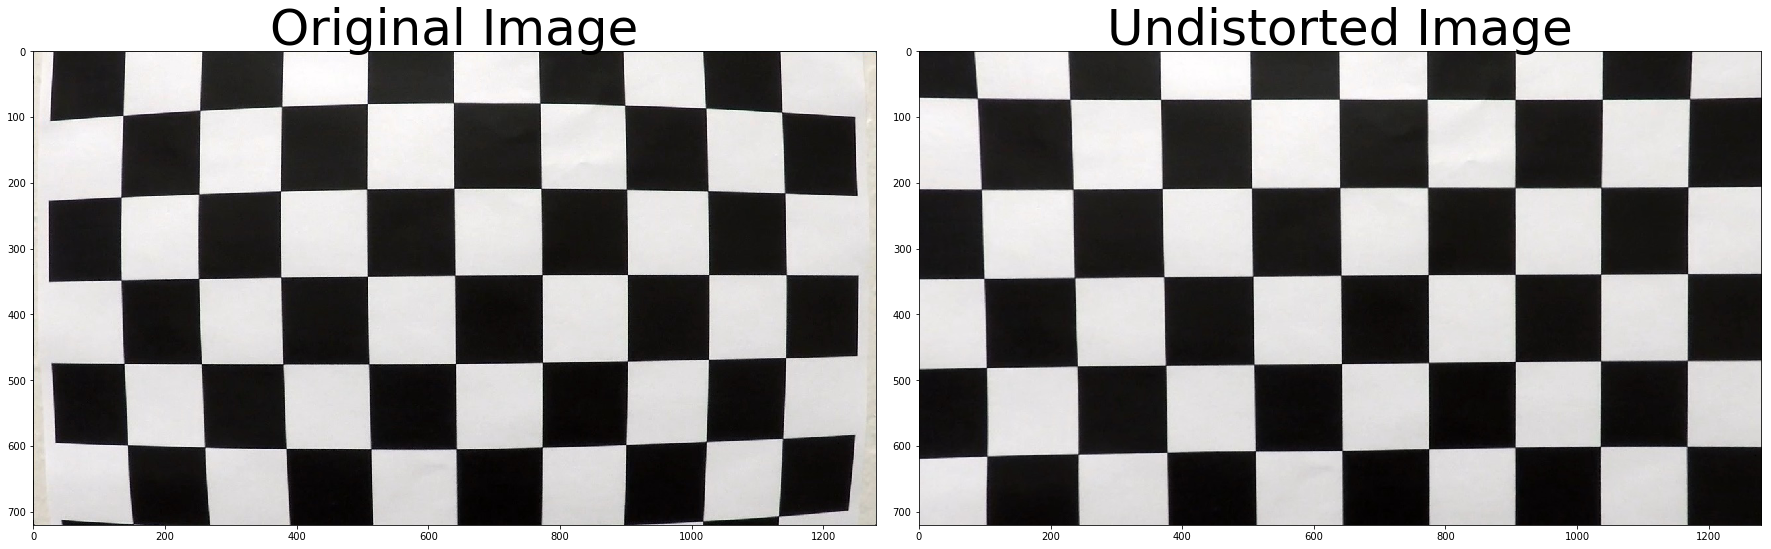

In [5]:
#Showing just one example of distortion correction

%matplotlib inline

img = mpimg.imread('./camera_cal/calibration1.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)

undst = cv2.undistort(img, mtx, dist, None, mtx)

ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [6]:
# Save image

cv2.imwrite('output_images/Undist_calibration1.jpg',cv2.cvtColor(undst, cv2.COLOR_RGB2BGR))

True

# 2. Pipeline Test Images

## 2.1. Example of distortion corrected image

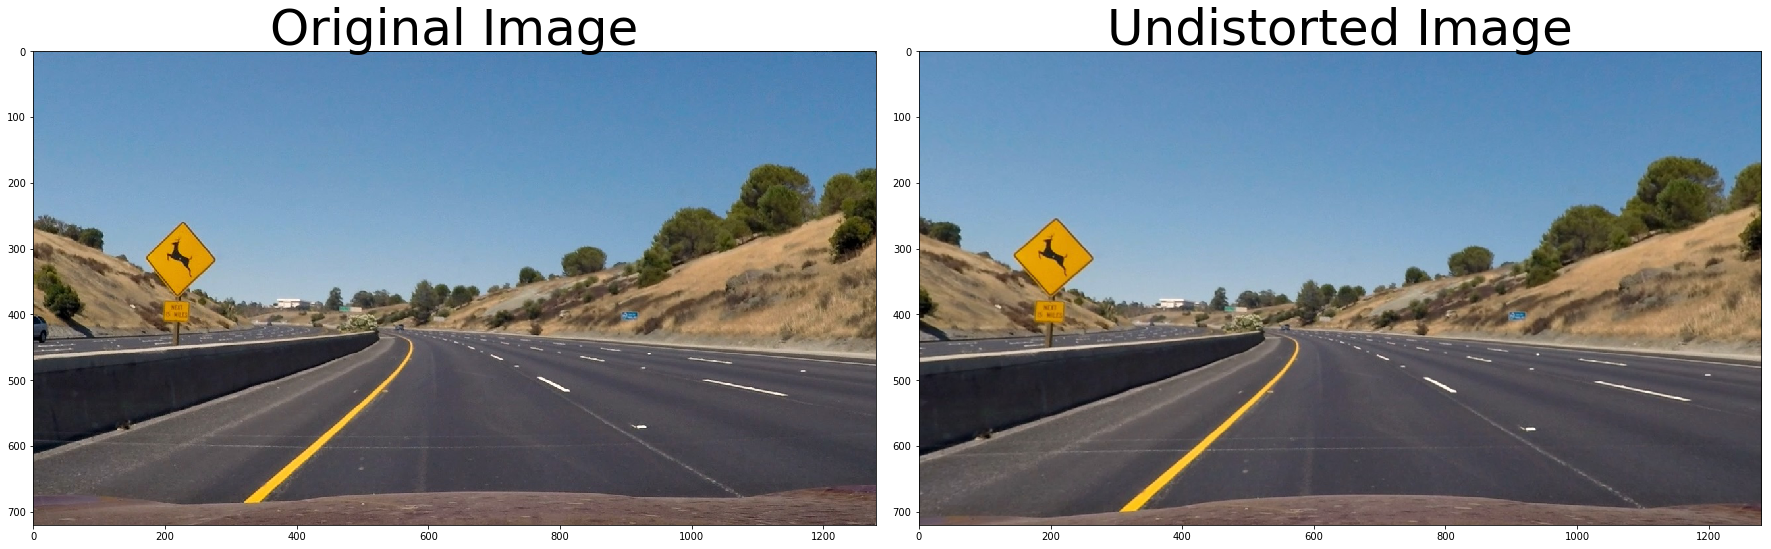

In [7]:
#Showing just one example of distortion correction in test image

%matplotlib inline

img = mpimg.imread('./test_images/test2.jpg') #Just a sample image to show the distortion correction

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)

#This is the line that performs the undistortion
undst = cv2.undistort(img, mtx, dist, None, mtx)

ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [8]:
# Save image

cv2.imwrite('output_images/Undist_test2.jpg',cv2.cvtColor(undst, cv2.COLOR_RGB2BGR))

True

## 2.2. Creation of the Thresholded binary image

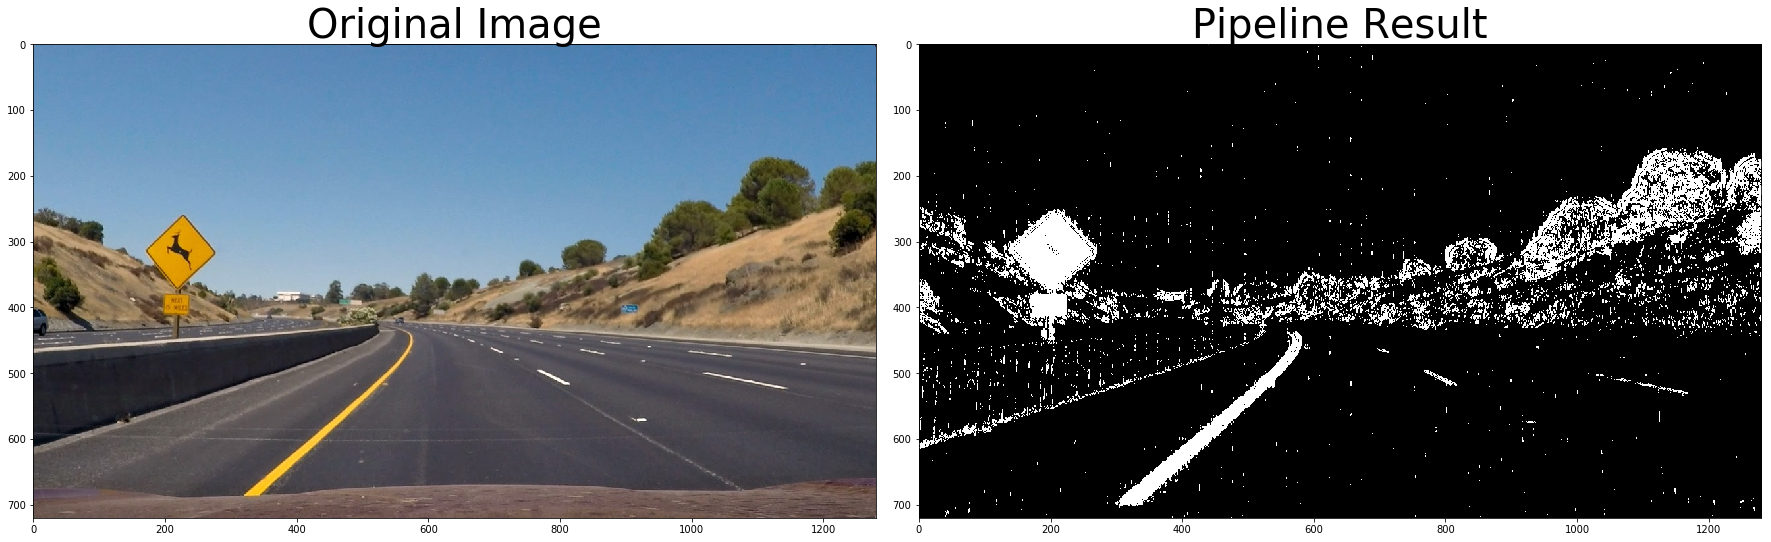

In [9]:
# Pipeline to create thresholded images.
# The threshold parameters are the result of severals trial and errors with different images.

def pipeline(img, s_thresh=(130, 255), sx_thresh=(8, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    # Used S channel for better results
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x 
    
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    # Sum both channels together and set to 1 any value above that after the addition.
    binary = s_binary + sxbinary
    binary[(binary>1)] = 1

    return binary
    
# Example using undistorted image from previous paragraph (Undist_test2.jpg) 
binary_thresh = pipeline(undst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_thresh, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [10]:
# Save image
binary_thresh = cv2.convertScaleAbs(binary_thresh, alpha=(255.0))
cv2.imwrite('output_images/Binary_test2.jpg' ,cv2.cvtColor(binary_thresh, cv2.COLOR_GRAY2RGB))

True

## 3 Perspective transformation

In [11]:
img_size=(undst.shape[1],undst.shape[0])

# Source points from the original picture
src = np.float32([[(img_size[0] / 2) - 45, img_size[1] / 2 + 90],[((img_size[0] / 6) - 8), img_size[1]],[(img_size[0] * 5 / 6) + 34, img_size[1]],[(img_size[0] / 2 + 45), img_size[1] / 2 + 90]])

# Destination points all set to conform a rectangular disposition
dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],[(img_size[0] * 3 / 4), 0]])

print(src)
print (dst)

[[  595.           450.        ]
 [  205.33332825   720.        ]
 [ 1100.66662598   720.        ]
 [  685.           450.        ]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


In [12]:
# Get the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
 
# Computed the inverse perspective transform
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image to a top-down view
warped = cv2.warpPerspective(undst, M, img_size, flags=cv2.INTER_LINEAR)

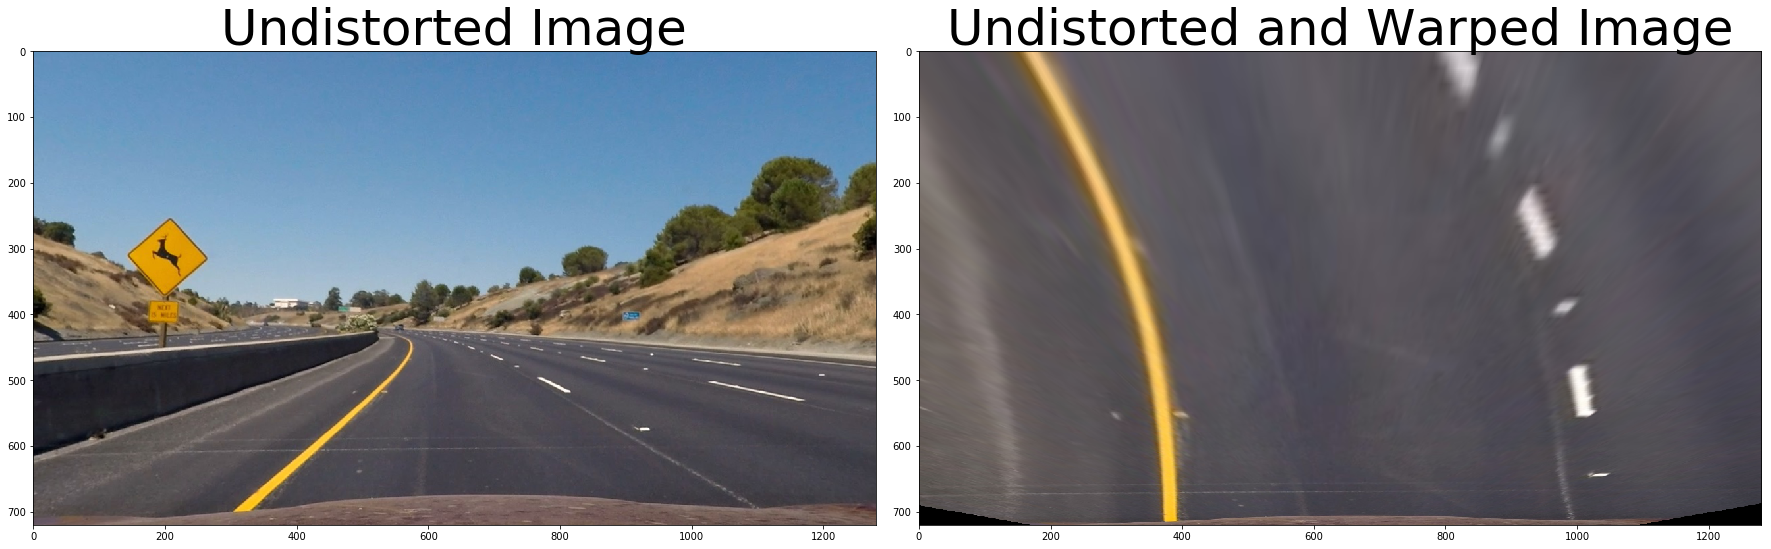

In [13]:
# Display undistorted and bird's eye (warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undst)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [14]:
# Save image

cv2.imwrite('output_images/Warped_test2.jpg',cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))

True

### Perspective transformation of thresholded image

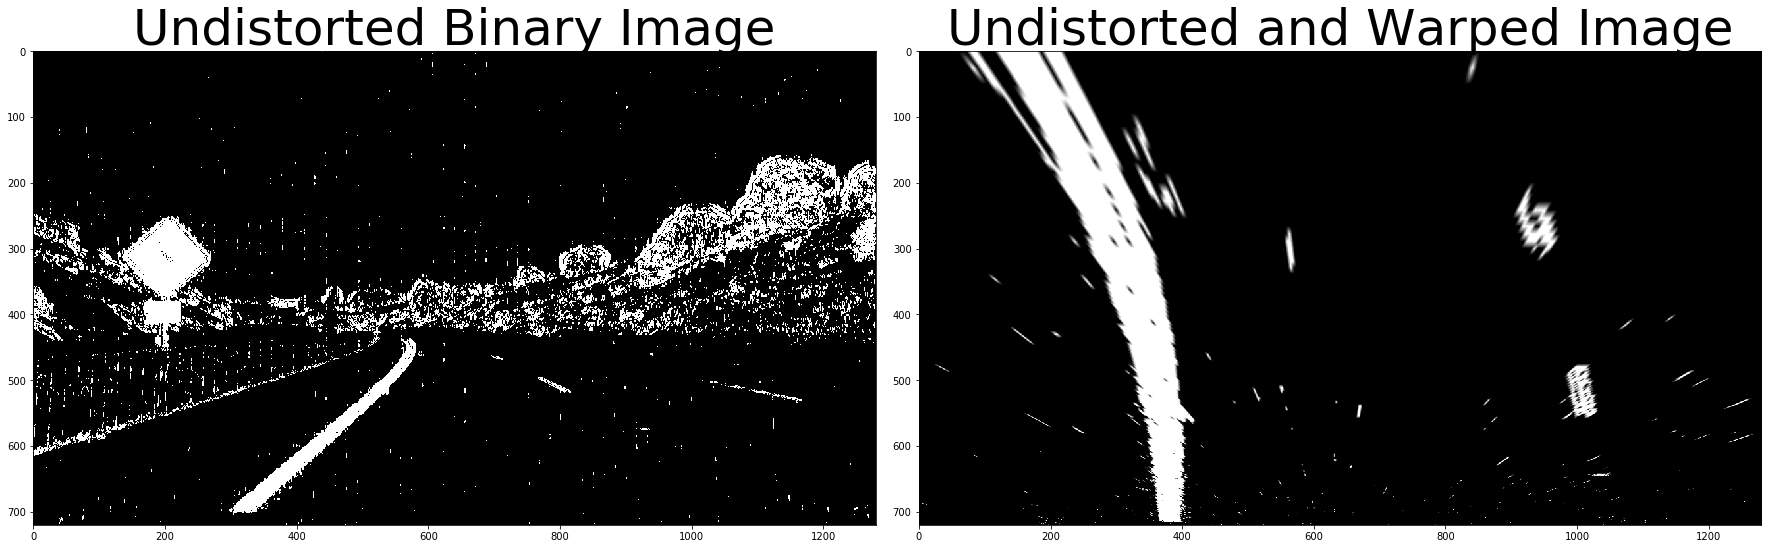

In [16]:
# Warping the binary image
binary_warped = cv2.warpPerspective(binary_thresh, M, img_size, flags=cv2.INTER_LINEAR)

# Display undistorted binary and warped (birds eye)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_thresh, cmap='gray')
ax1.set_title('Undistorted Binary Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 4 Identify lane-line pixels and fit their positions with a polynomial

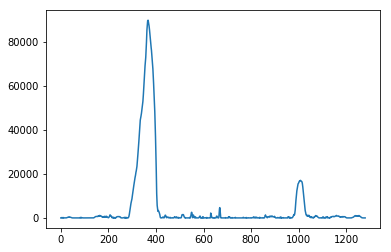

In [17]:
# Identification of the starting point of the lanes on the bottom of the picture
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [19]:
# Identification of the lane pixels and calculation of the curved polynomial for each lane

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and visualize the result
out_img1 = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img1,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img1,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
except ValueError:
    # Avoids an error if the above is not implemented fully
    pass

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

### Visualization of the polynomial

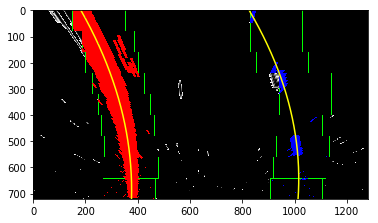

In [20]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img1[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img1[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(out_img1)

### Visualizing the result here as well

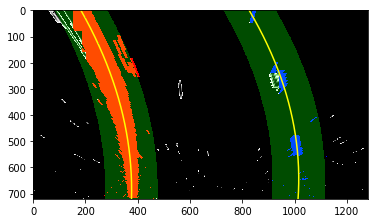

In [22]:
# Create an image to draw on and an image to show the selection window
out_img2 = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img2)

# Color in left and right line pixels
out_img2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
out_img2 = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(out_img2)

In [23]:
# Save image

cv2.imwrite('output_images/Polynomial1_test2.jpg',cv2.cvtColor(out_img1, cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/Polynomial2_test2.jpg',cv2.cvtColor(out_img2, cv2.COLOR_RGB2BGR))

True

## 5 Calculate the radius of curvature of the lane and the position of the vehicle with respect to center.

In [24]:
#Calculate Radii
    
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)# maximum y-value, corresponding to the bottom of the image

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Values are showm from the sample image
print('Radius of Curvature left side: %d m'%left_curverad)
print('Radius of Curvature rignt side: %d m'%right_curverad)

Radius of Curvature left side: 399 m
Radius of Curvature rignt side: 359 m


In [25]:
# Calculate the deviation from center line (estimated) no matter wich side.
ctr=abs((((rightx_base-leftx_base)/2)+leftx_base-midpoint)*xm_per_pix) 
print('%.2f m off Centerline'%ctr)

0.25 m off Centerline


## 6 Provide an example image

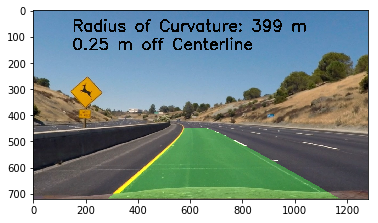

In [26]:
# Drawing

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)

#Add text to the frame
rad=left_curverad #I just took the left line as the reference
text='Radius of Curvature: %d m'%rad

# Calculate de deviation off centerline any side.
ctr=abs((((rightx_base-leftx_base)/2)+leftx_base-midpoint)*xm_per_pix) 
text2='%.2f m off Centerline'%ctr

#Insert Text on frame
undst_radius=cv2.putText(result,(text), (150,80), cv2.FONT_HERSHEY_SIMPLEX, 2, 0,5)
undst_radius_ctr=cv2.putText(undst_radius,(text2), (150,150), cv2.FONT_HERSHEY_SIMPLEX, 2, 0,5)

plt.imshow(undst_radius_ctr)

In [27]:
# Save image

cv2.imwrite('output_images/HighlightLane_test2.jpg',cv2.cvtColor(undst_radius_ctr, cv2.COLOR_RGB2BGR))

True

# 3 Video Pipeline

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
def process_image(image):

    # Blanca Lopez Pipeline
    
    #This is the line that performs the undistortion
    undst = cv2.undistort(image, mtx, dist, None, mtx)
    
    #This is the line that performs the threshold
    thresholded = pipeline(undst)
    
    #This is the line that performs the warping
    binary_warped = cv2.warpPerspective(thresholded, M, img_size, flags=cv2.INTER_LINEAR)
    
   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    # Drawing

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    
    
    #Calculate Radii
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)# maximum y-value, corresponding to the bottom of the image
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    
    #Add text to the frame
    rad=(left_curverad+right_curverad)/2 #I get the mean of both lines
    text='Radius of Curvature: %d m'%rad
    
    # Calculate de deviation off centerline any side.
    ctr=abs((((rightx_base-leftx_base)/2)+leftx_base-midpoint)*xm_per_pix) 
    text2='%.2f m off Centerline'%ctr

    #Insert Text on frame
    undst_radius=cv2.putText(result,(text), (150,80), cv2.FONT_HERSHEY_SIMPLEX, 2, 0,5)
    undst_radius_ctr=cv2.putText(undst_radius,(text2), (150,150), cv2.FONT_HERSHEY_SIMPLEX, 2, 0,5)


    return undst_radius_ctr    

In [30]:
video_output = 'project_video_Processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_Processed.mp4
[MoviePy] Writing video project_video_Processed.mp4


100%|█████████▉| 1260/1261 [03:51<00:00,  5.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_Processed.mp4 

CPU times: user 1min 50s, sys: 2.39 s, total: 1min 52s
Wall time: 3min 54s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))
